# Classifiation of Dry Bean dataset with a Neural Networks

## Introduction

Dry Bean dataset could be downloaded from UC Irvine Machine Learning Repository at [this link](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset). 

It is an Excel file with image data of 13611 beans categorised in 7 different types. Their classification model is based on all 13611 bean images. The dataset has 16 features: 12 describing dimensions and 4 - their shape form.

### Imports

In [100]:
%matplotlib inline

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
import imblearn
print(imblearn.__version__)

0.10.1


In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer

In [104]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

## 1. Load the Dataset

The Dry Bean Dataset is loaded and stored in `dry_beans_dataset`. A brief check confirms that it has 13611 rows and 17 features

In [105]:
dry_beans_dataset = pd.read_excel("Datasets/Dry_Beans.xlsx")

In [106]:
dry_beans_dataset.shape

(13611, 17)

## 2. Data Cleaning and Exploratory Data Analysis

Column titles, however, do not meet Python convention (see below). All words should be with small letters, and space should be replaced with underscore. Therefore, the first task is to make row headings Pythonic style.

In [107]:
dry_beans_dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


#### 2.1. Rename features

In [108]:
dry_beans_dataset.rename(columns = {"Area": "area", "Perimeter": "perimeter", "MajorAxisLength": "major_axis_length", "MinorAxisLength": "minor_axis_length", "AspectRation": "aspect_ratio", "Eccentricity": "eccentricity", "ConvexArea": "convex_area", "EquivDiameter": "equiv_diameter", "Extent": "extent", "Solidity": "solidity", "roundness": "roundness", "Compactness": "compactness", "ShapeFactor1": "shape_factor_1", "ShapeFactor2": "shape_factor_2", "ShapeFactor3": "shape_factor_3", "ShapeFactor4": "shape_factor_4", "Class": "class"}, inplace = True)

In [109]:
dry_beans_dataset.head()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4,class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


It could be seen from the DataFrame above that all but the last ("class") features hold numeric values. 

It is explained that:
1. **area (A)** is the area of a bean zone and the number of pixels within its boundaries 
2. **perimeter (P)** is bean circumference defined as the length of its border
3. **major_axis_length (L)** shows the distance between the ends of the longest line that can be drawn from a bean
4. **minor_axis_length (l)** shows the longest line that can be drawn from the bean while standing perpendicular to the main axis
5. **aspect_ratio (K)** defines the relationship between L and l. 
6. **eccentricity (Ec)** is the egccentricity of the ellipse having the same moments as the region 
7. **convex_area (C)** shows the number of pixels in the smallest convex polygon that can contain the area of a bean seed
8. **equivalent_diameter (Ed)** is the diameter of a circle having the same area as a bean seed area
9. **extent (Ex)** is the ratio of the pixels in the bounding box to the bean area
10. **solidity (S)**, also known as convexity, shows the ratio of the pixels in the convex shell to those found in beans
11. **roundness (R)** is calculated with the following formula: (4piA)/(P^2)
12. **compactness (CO)** measures the roundness of an object: Ed/L
13. **shape_factor_1 (SF1)**; **shape_factor_2 (SF2)**; **shape_factor_3 (SF3)**; **shape_factor_4 (SF4)**
14. **class**: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira. 

#### 2.2. Check data types and for missing values

A brief check confirms that all features hold numeric values (both *int* and *float* type), and only those in the last column are "object" type. There are not missing values in the dataset.

In [110]:
dry_beans_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               13611 non-null  int64  
 1   perimeter          13611 non-null  float64
 2   major_axis_length  13611 non-null  float64
 3   minor_axis_length  13611 non-null  float64
 4   aspect_ratio       13611 non-null  float64
 5   eccentricity       13611 non-null  float64
 6   convex_area        13611 non-null  int64  
 7   equiv_diameter     13611 non-null  float64
 8   extent             13611 non-null  float64
 9   solidity           13611 non-null  float64
 10  roundness          13611 non-null  float64
 11  compactness        13611 non-null  float64
 12  shape_factor_1     13611 non-null  float64
 13  shape_factor_2     13611 non-null  float64
 14  shape_factor_3     13611 non-null  float64
 15  shape_factor_4     13611 non-null  float64
 16  class              136

#### 2.3. Display beans per type

The plot below shows that the dataset is quite imbalanced. Some beans are over-sampled (e.g., "Dermason"), whereas others - under-sampled (e.g., "Bombay").

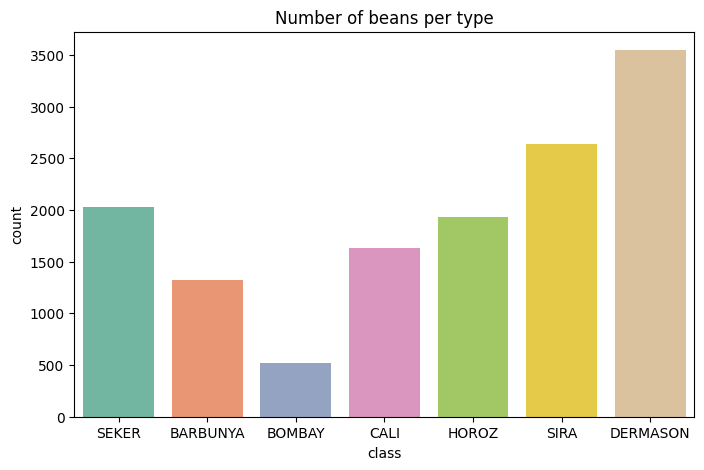

In [111]:
plt.figure(figsize = (8, 5))
sns.countplot(x = dry_beans_dataset["class"], palette="Set2")
plt.title("Number of beans per type")
plt.show()

#### 2.4. Display distribution of values in each feature

Labels are removed from the dataset before displaying values distribution. The features are stored in a new variable `dry_beans_features`.

In [112]:
dry_beans_features = dry_beans_dataset.drop(["class"], axis = 1)

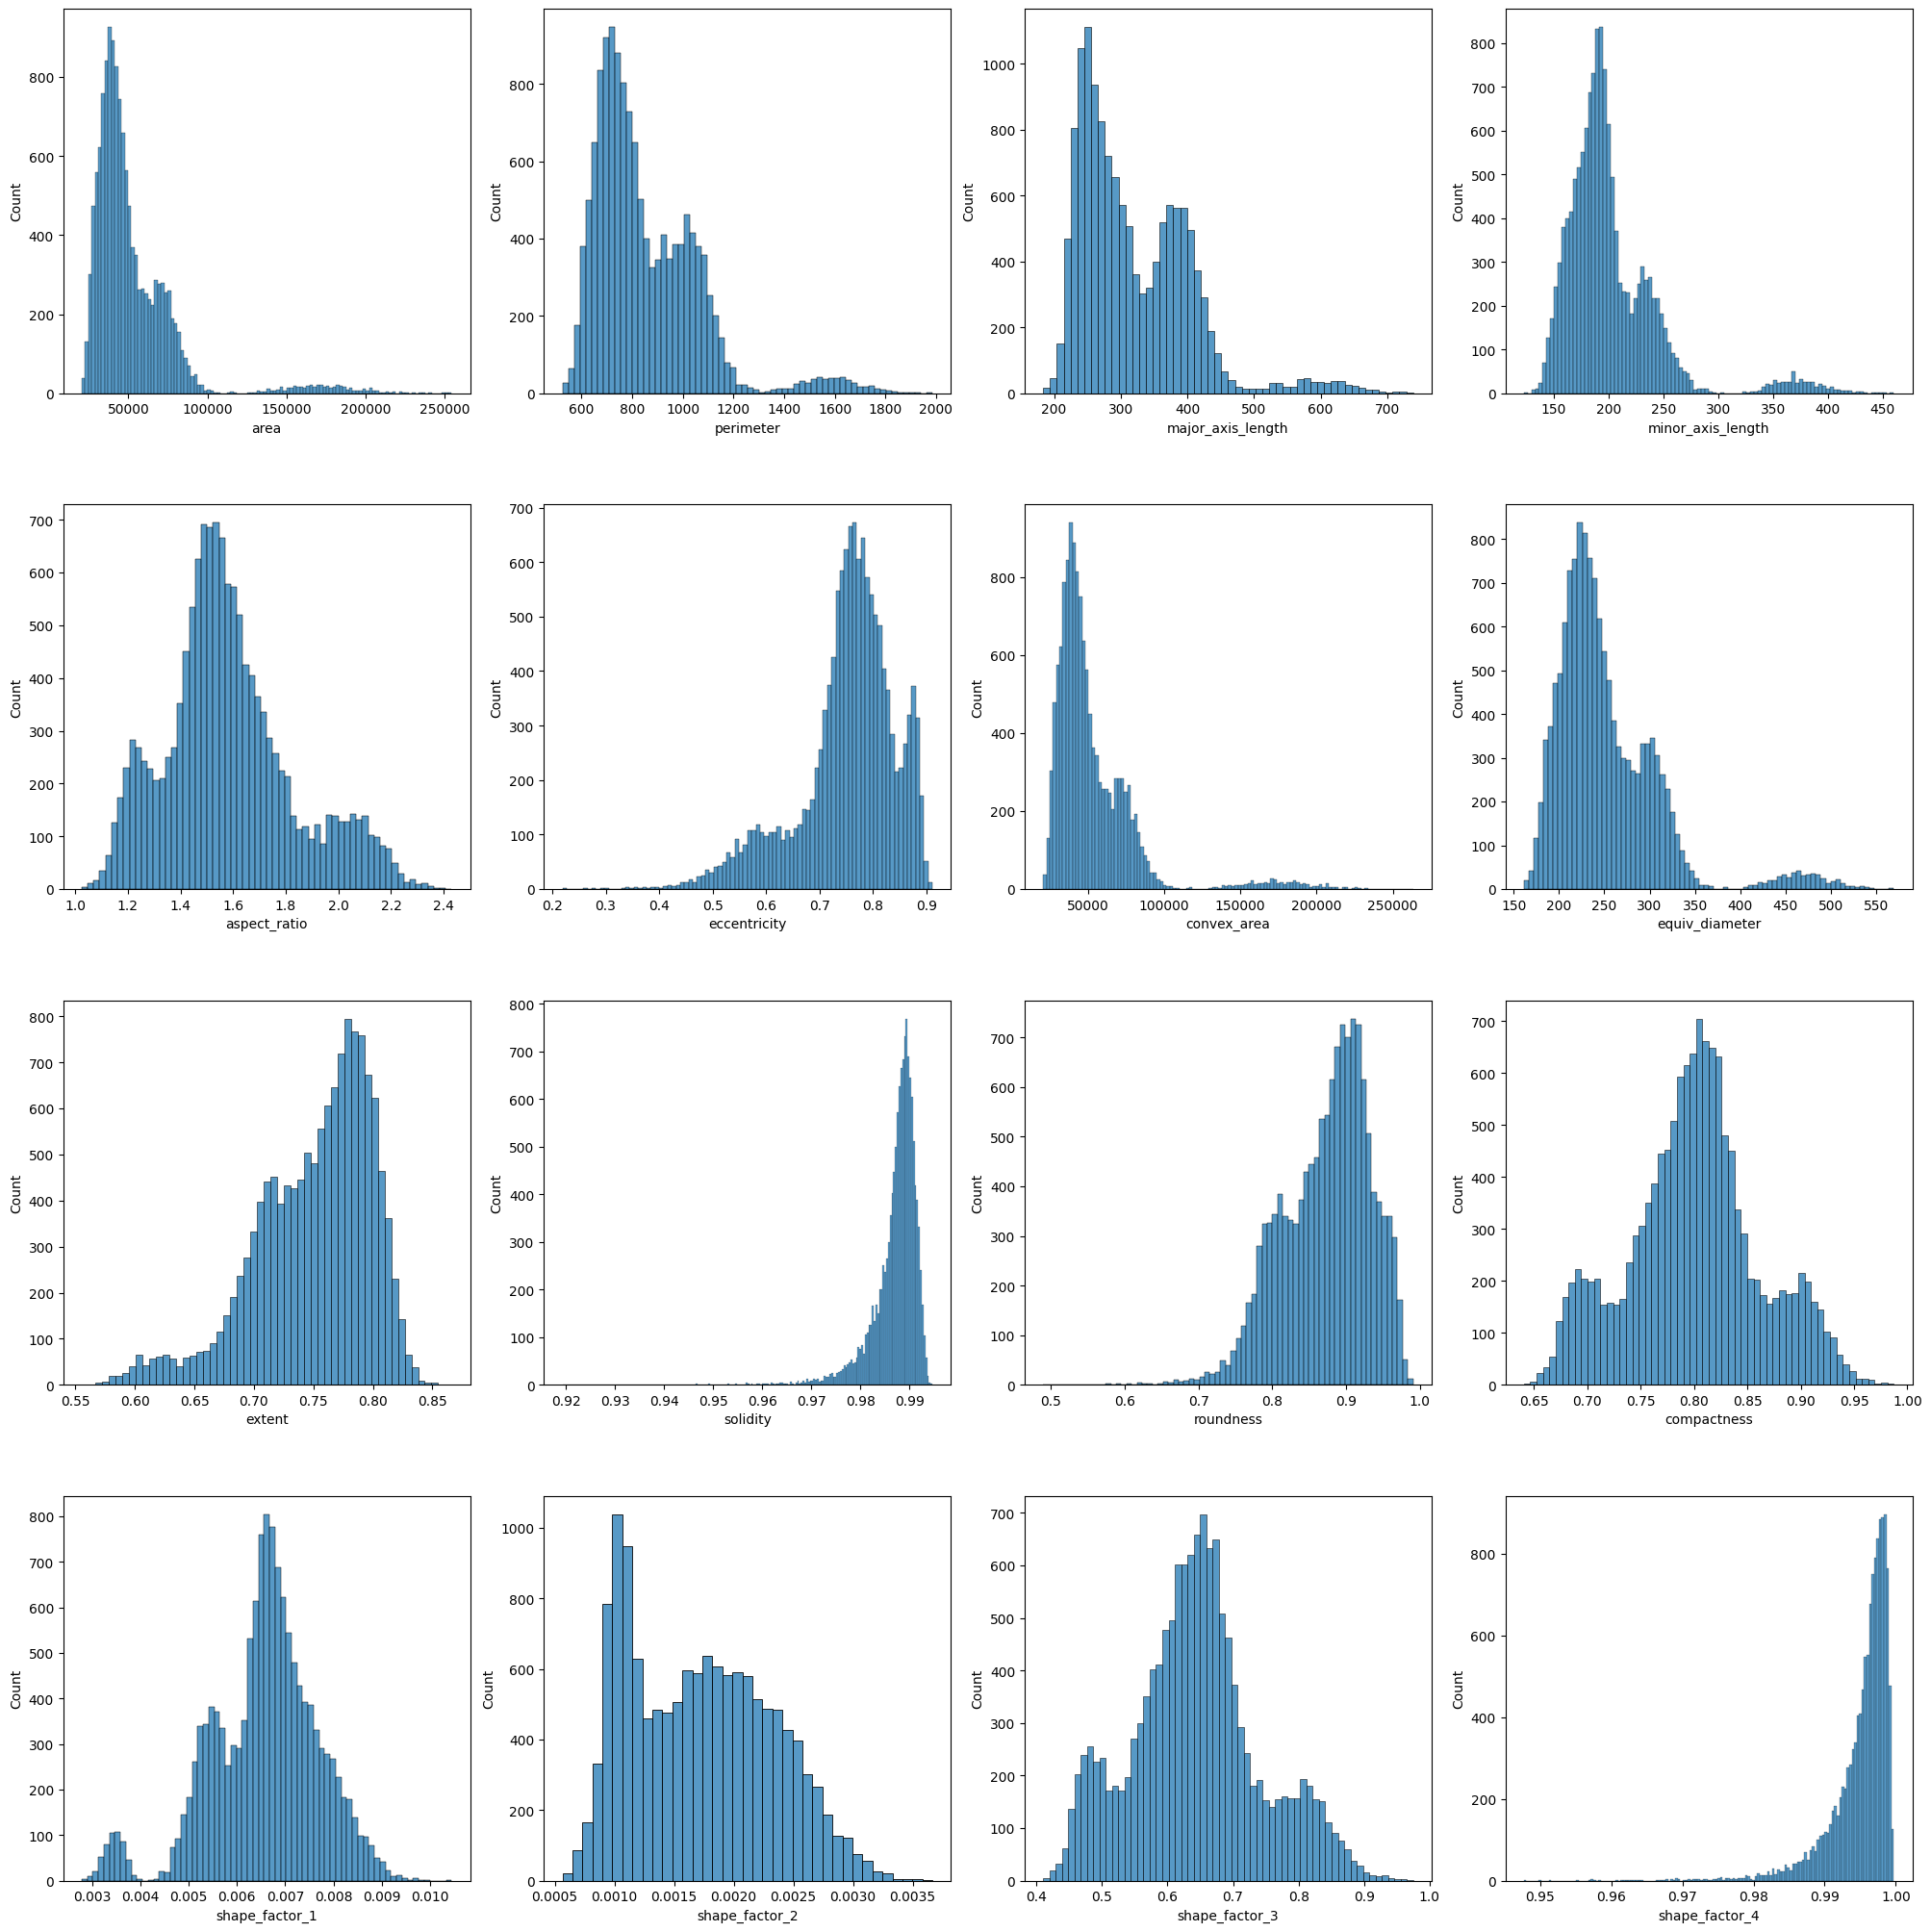

In [113]:
# Plot features value distribution
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20, 20))
index = 0

axs = axs.flatten()
for k, v in dry_beans_features.items():
    sns.histplot(v, ax = axs[index])
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

The plots above show that values in some features have similar distribution (e.g., "area", "perimeter", "major" and "minor" axis length), whereas others are completely different. For example, neither "shape factor" looks similar to another. Some distributions are, more or less, bi- or trimodal, whereas others have only one mode. Distribution shapes of some features suggest existence of outliers. 

#### 2.5. Check for outliers

The dots outside the boxplots below indicate a lot of outliers in the data. Those were removed (from all features) but the Neural Network didn't performed better with "cleaned" data. Also, it turned out that one of the bean types (Bombay) is significantly larger that the others, and the whole class was removed as an "outlier" (which negatively affected the whole classification task). Therefore, the final model works with the whole dataset, as created by its authors. 

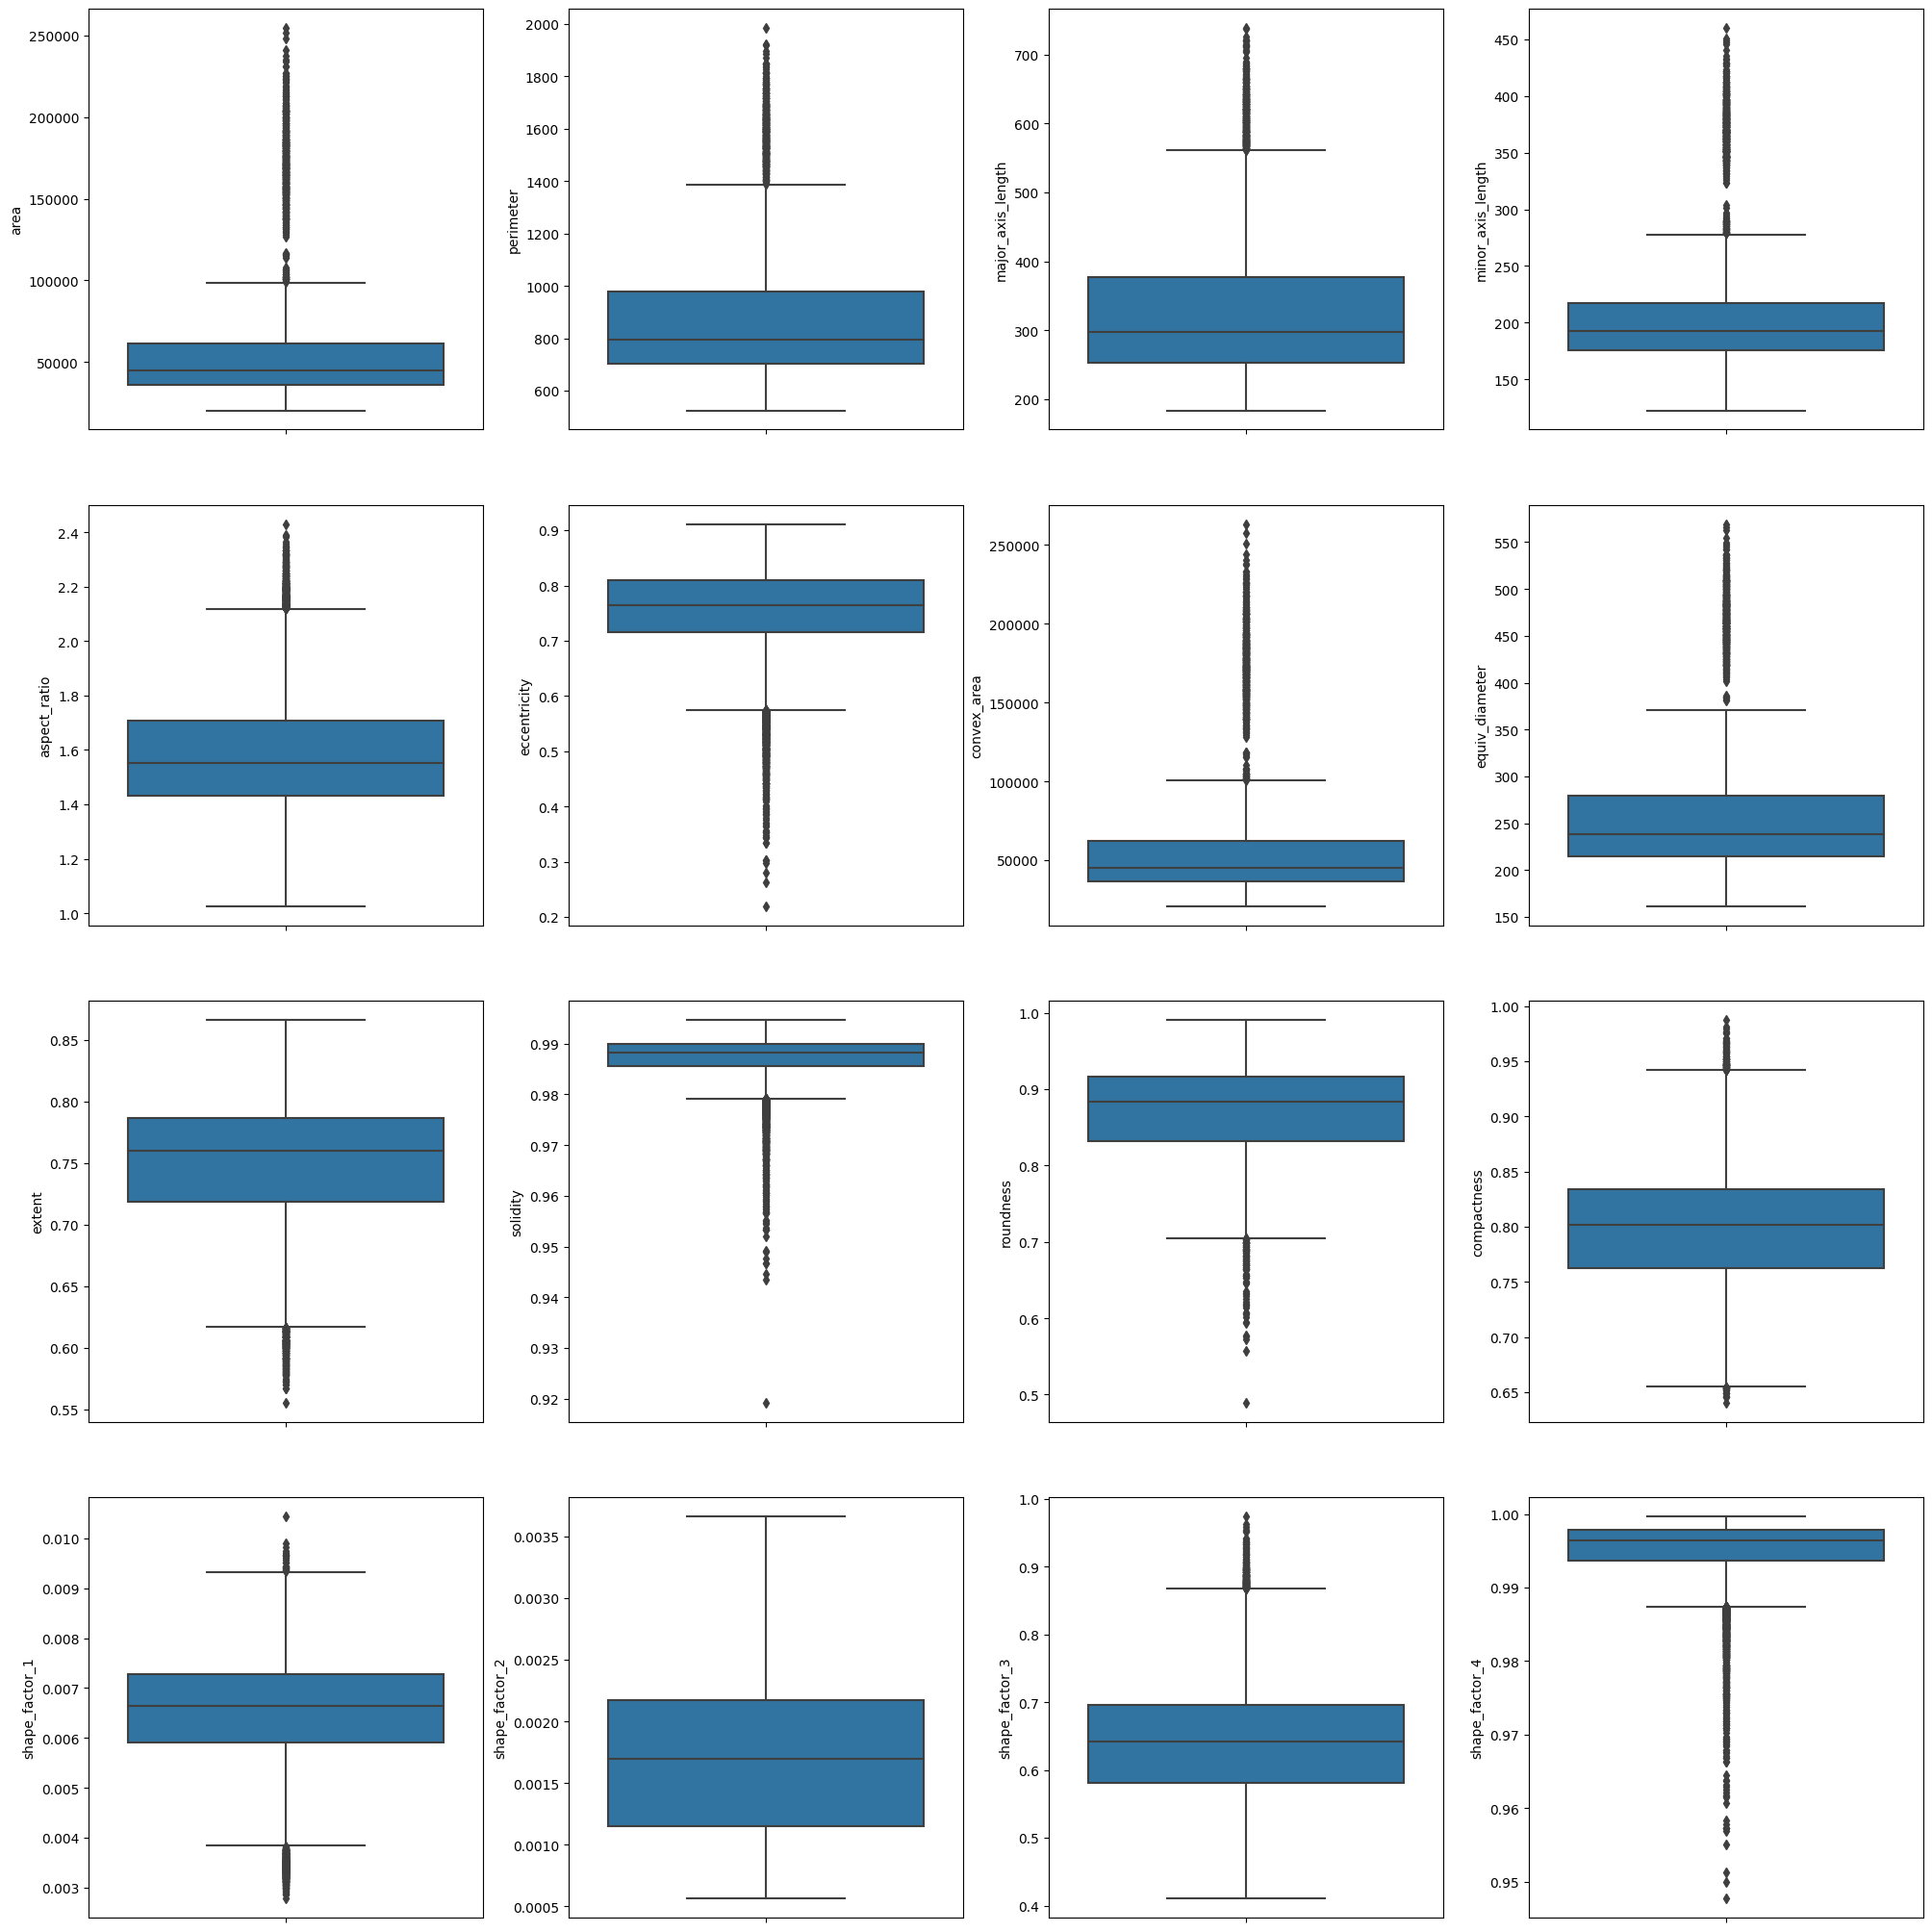

In [114]:
# Display boxplots per feature
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20, 20))
idx = 0
axs = axs.flatten()
for k, v in dry_beans_features.items():
    sns.boxplot(y = k, data = dry_beans_features, ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

## 3. Data pre-processing

`SMOTE` module of `imblearn.over_sampling` was used to address imbalanced data. It "added" more samples to the under-sampled classes so as the dataset had equal number of bean categories at the end. The number of samples reached more than 20000 but this endeavour didn't improve the Neural Network's performance. Therefore, it was abandoned.

#### 3.1. Train - validation - test  split

Imbalanced data impeded "manual" stratified splitting into training, validation, and training sets. For this reason, although highly undesirable for Deep Learning models, `train_test_split` of `sklearn` was used instead. Prior to that, however, features and labels ("class") were separated.

In [115]:
def separate_features_from_labels(dataset):
    """
    Function: separates features from labels (classes).
    
    Parameters: dataset.
    
    Returns: tuple of features and labels as np.array.
    """
    return (dataset.drop("class", axis = 1).values, dataset["class"].values)

In [116]:
(features, labels) = separate_features_from_labels(dry_beans_dataset)

First, the dataset is split into "train and validation" and "testing" sets; thereafter, the same operation is applied for splitting "training" and "validation" data. Test size is set to 10%; it is better to have more samples for training. Size of validation data is the same as that of the testing one. Labels are used for stratifying the samples into training, validation, and testing ones.

In [117]:
trval_features, test_features, trval_labels, test_labels = train_test_split(features, labels, test_size = 0.10, stratify = labels, random_state = 42)

train_features, val_features, train_labels, val_labels = train_test_split(trval_features, trval_labels, test_size = len(test_labels), stratify = trval_labels, random_state = 42)

It is very important to check datasets' shape; model training is impossible if they are not in the proper form. 

In [118]:
train_features.shape, train_labels.shape, val_features.shape, val_labels.shape, test_features.shape, test_labels.shape

((10887, 16), (10887,), (1362, 16), (1362,), (1362, 16), (1362,))

#### 3.2. Display beans class distribution

Also, it is important to check if all three sets hold similar number of samples per category. The function below displays distribution of labels in each dataset.

In [119]:
def display_class_distribution(indexed_data, dataset, title = None):
    """
    Function: displays number of items per class.
    
    Parameters: indexed data (X.index) and dataset (X).
    
    Returns: barchart of number of items per class.
    """
    plt.figure(figsize = (7, 5))
    plt.bar(indexed_data, dataset)
    plt.xlabel("Bean type")
    plt.ylabel("Count")
    if title is not None:
        plt.title(title)
    plt.show()

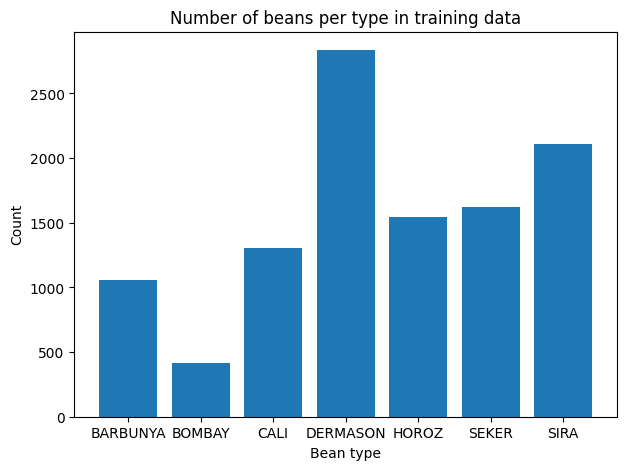

In [120]:
display_class_distribution((pd.DataFrame(train_labels).groupby(0).size()).index, (pd.DataFrame(train_labels).groupby(0).size()), "Number of beans per type in training data")

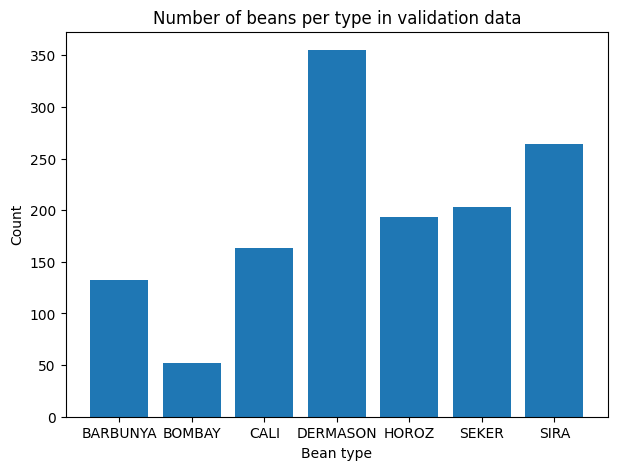

In [121]:
display_class_distribution((pd.DataFrame(val_labels).groupby(0).size()).index, (pd.DataFrame(val_labels).groupby(0).size()), "Number of beans per type in validation data")

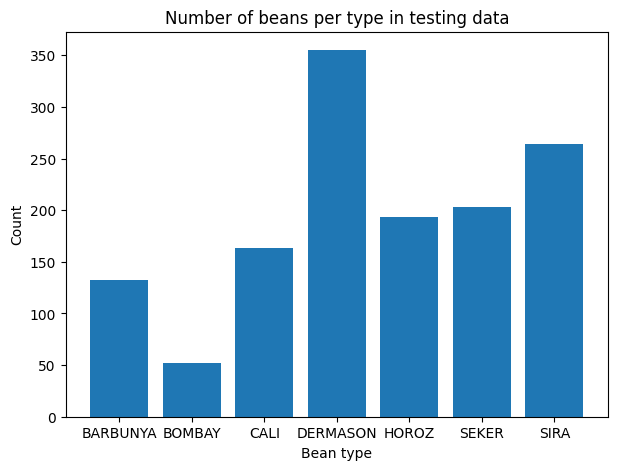

In [122]:
display_class_distribution((pd.DataFrame(test_labels).groupby(0).size()).index, (pd.DataFrame(test_labels).groupby(0).size()), "Number of beans per type in testing data")

Everything seems alright: all three sets have similar samples distribution (in terms of the bean type they belong to).

#### 3.3. Normalize feature values

Both Neural Networks and Machine Learning algorithms expect to get scaled features. Thus, the function below makes all feature values in the range between 0 and 1 (it does the same as `Min_Max_Scaler` of `sklearn`).

In [123]:
def min_max_scaler(features):
    """
    Function: scales values betweeb 0 and 1.
    
    Parameters: dataset as an NumPy array.
    
    Returns: scaled NumPy array in float32 dtype.
    """
    max_n = np.max(features)
    min_n = np.min(features)
    features_scaled = np.array([(x - min_n) / (max_n - min_n) for x in features])
    return features_scaled.astype("float32")

In [124]:
train_features = min_max_scaler(train_features)
val_features = min_max_scaler(val_features)
test_features = min_max_scaler(test_features)

A brief check confirms the scaling was successful.

In [125]:
train_features.min(), train_features.max(), train_features.dtype

(0.0, 1.0, dtype('float32'))

#### 3.4. Convert labels to NumPy matrix (for NN)

The Neural Network would expect numeric values; so far, "labels" hold *strings* of bean types. Therefore, they are converted into a NumPy matrix.

In [126]:
train_labels_np = pd.get_dummies(train_labels).to_numpy()
val_labels_np = pd.get_dummies(val_labels).to_numpy()
test_labels_np = pd.get_dummies(test_labels).to_numpy()

In [127]:
print(train_labels_np)

[[False False False ... False False  True]
 [False False False ... False  True False]
 [False False False ... False False False]
 ...
 [False False  True ... False False False]
 [False False False ...  True False False]
 [False False False ... False False  True]]


## 4. Build, train, and evaluate a classifier with a Neural Network

To avoid clutter from existing models and layers (when model is being fune-tuned several times), especially when memory is limited, `clear_session()` resets all prior state generated by Keras.

In [128]:
tf.keras.backend.clear_session()

#### 4.1. Build the model

Various architectures were tested but neither returned an accuracy higher than 62%-64%. Number of neurons were increased, thereafter decreased. More layers were added, then removed. This is a relatively complex model for this small dataset. The final version has Dropout layers, which help for avoiding overfitting on the training data.

In [129]:
input_shape = train_features.shape[1]

In [130]:
model = Sequential([
    Input(input_shape),
    Dense(64, activation = "relu"),
    Dropout(0.1),
    Dense(128, activation = "relu"),
    Dropout(0.1),
    Dense(256, activation = "relu"),
    Dropout(0.1),
    Dense(512, activation = "relu"),
    Dropout(0.1),
    Dense(256, activation = "relu"),
    Dropout(0.1),
    Dense(128, activation = "relu"),
    Dropout(0.1),
    Dense(64, activation = "relu"),
    Dense(7, activation = "softmax")
])

In [131]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               1

Almost 350 000 trainable parameters for a dataset of 13000 samples with almost straightforward data seems too much. Nonetheless, it is trained and evaluated.
Multiclass problems require "categorical_crossentropy" loss function; model's performance is evaluated for its "accuracy". Gradient Descent is computed with "Adam" optimizer with reduced learning rate (for better results).

In [132]:
model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
             metrics = ["accuracy"])

#### 4.2. Train the model

The net gets training and validation data, which are passed through it for 50 epochs.

In [133]:
history = model.fit(train_features, train_labels_np,
         epochs = 50,
         validation_data = (val_features, val_labels_np), verbose = 0)

The plots below show that the model couldn't converge. Both training and validation loss stopped to fall after the 30th epoch. Accuracy barely reached 50% on the validation set.

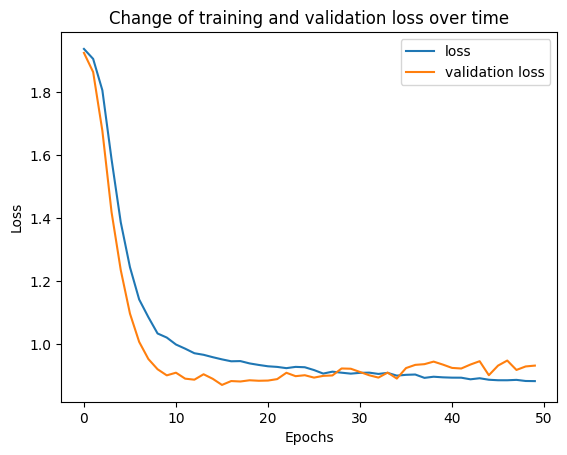

In [134]:
# Plot loss dynamics 
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

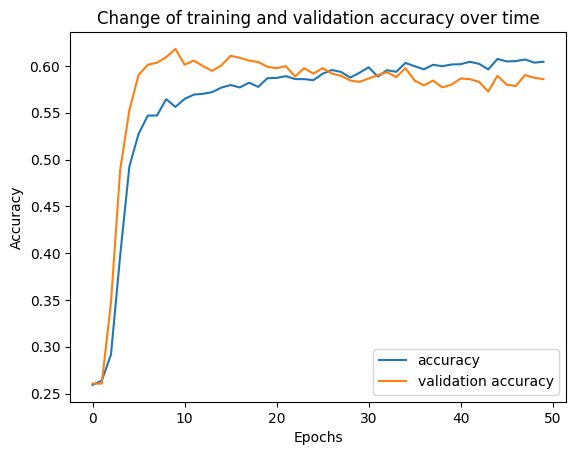

In [135]:
# Plot accuracy dynamics
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Change of training and validation accuracy over time")
plt.show()

#### 4.3. Evaluate the model

The code lines below show that the model's accuracy on the testing set is 55%, which is quite unsatisfactory.

In [136]:
model_performance = model.evaluate(test_features, test_labels_np)

43/43 [==============================] - 0s 1ms/step - loss: 0.9574 - accuracy: 0.6013


In [137]:
print(f"Model loss on testing data is {model_performance[0]}")
print(f"Model accuracy on testing data is {model_performance[1]*100}%")

Model loss on testing data is 0.9574164748191833
Model accuracy on testing data is 60.13215780258179%
